In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
batch_size = 64
noise_dim = 128

In [139]:
vae_transform = transforms.Compose([
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root = "./data",train = True, transform = vae_transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, shuffle = True)


In [4]:
img, label = next(iter(train_loader))
print(img.shape)

torch.Size([64, 3, 32, 32])


In [5]:
class Reshape(nn.Module):
    def __init__(self, channels, height, width):
        super().__init__()
        self.c, self.h, self.w = channels, height, width
    def forward(self, x):
        return x.view(-1, self.c, self.h, self.w)

In [9]:
import torch
import matplotlib.pyplot as plt
import math

def generate_and_plot(generator, z_dim, num_images=6, device='cuda'):
    

    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        # Generate noise for all images
        z = torch.randn(num_images, z_dim,1,1).to(device)
        fake_images = generator(z).cpu()  # [B, C, H, W]
        fake_images = (fake_images + 1)/2

    # Determine grid size
    grid_cols = int(math.sqrt(num_images))
    grid_rows = (num_images + grid_cols - 1) // grid_cols

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
    axes = axes.flatten()

    for i in range(num_images):
        img = fake_images[i].permute(1, 2, 0).numpy()  # [H,W,C]
        axes[i].imshow(img)
        axes[i].axis('off')

    # Turn off any unused axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [7]:
device = "cuda"
state_dict = torch.load("netG_epoch_199.pth",map_location="cpu")
Gen = Generator(1).to(device)
Gen.load_state_dict(state_dict)

<All keys matched successfully>

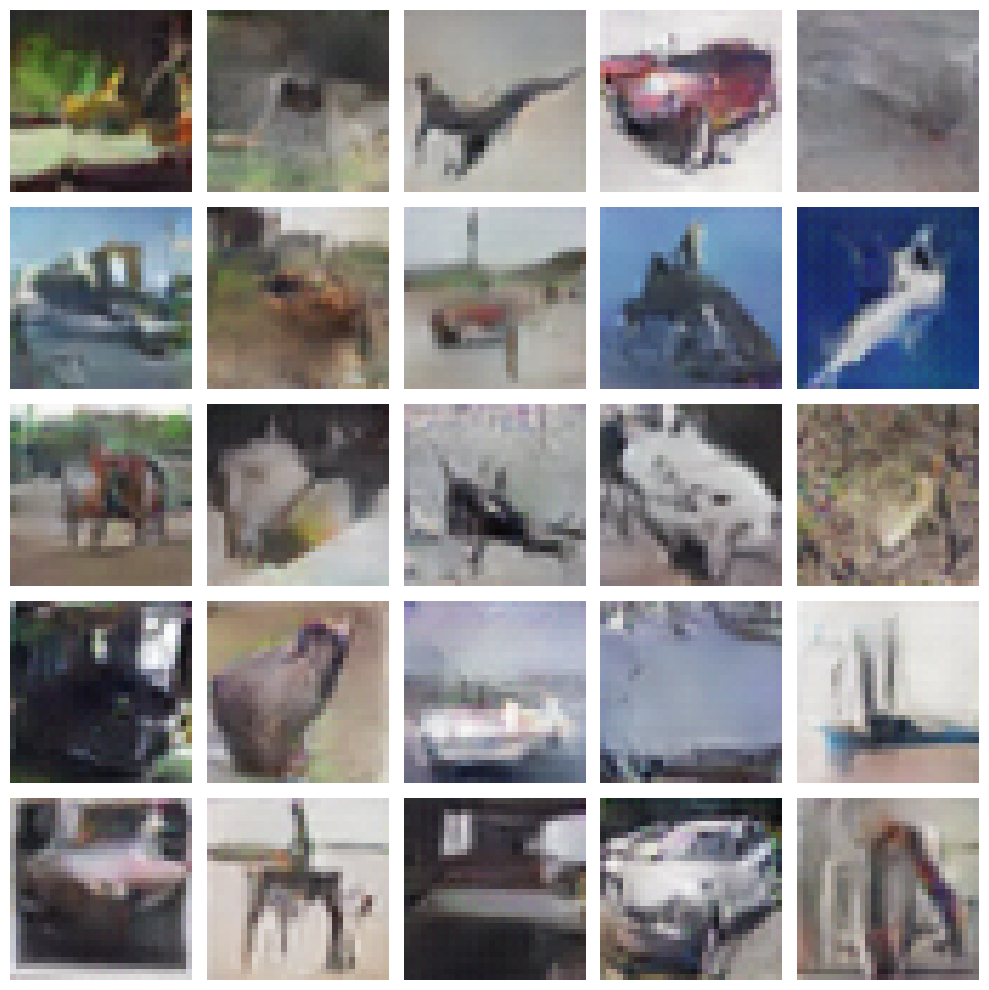

In [10]:
generate_and_plot(generator=Gen, z_dim=100,num_images=25)

In [8]:
class Vae_res_enc(nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_chan)
        )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=1, stride=2),
            nn.BatchNorm2d(out_chan)
        )
        
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        return self.activation(self.main(x) + self.shortcut(x))




In [9]:
class Encoder(nn.Module):
    def __init__(self,z_dim = 128):
        super().__init__()
        self.z_dim = z_dim
        self.MU = nn.Linear(512*4*4,z_dim)
        self.logvar = nn.Linear(512*4*4,z_dim)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.encode = nn.Sequential(
            Vae_res_enc(64,128),
            Vae_res_enc(128,256),
            Vae_res_enc(256,512),
            nn.Flatten()
        )
    def forward(self,x):
        x = self.stem(x)
        x = self.encode(x)
        mu = self.MU(x)
        logvar = self.logvar(x)
        return mu,logvar

In [10]:
class res_decoder(nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
            
            # Main path: learns the complex residual features for upsampling
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_chan, out_chan, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Conv2d(out_chan, out_chan, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_chan)
            )
            
            # Shortcut path: projects the input to match the output shape
        self.shortcut = nn.Sequential(
            nn.ConvTranspose2d(in_chan, out_chan, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_chan)
            )
            
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(self.main(x) + self.shortcut(x))


In [43]:
class Decoder(nn.Module):
    def __init__(self,z_dim = 128):
        super().__init__()
        self.to_rgb = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),

            nn.Tanh()
        )
        self.main = nn.Sequential(
            nn.Linear(z_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            Reshape(512, 4, 4),
            res_decoder(512, 512),       
            res_decoder(512, 256),       
            res_decoder(256, 128)       
        )
    def forward(self,x):
        out = self.main(x)
        out = self.to_rgb(out)
        return out

In [42]:
class VAE(nn.Module):
    def __init__(self,z_dim = 128):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self,x):
        mu,logvar = self.encoder(x)
        z = self.reparameterize(mu,logvar)
        recon = self.decoder(z)
        return recon,mu,logvar

In [44]:
def vae_loss(recon_x, x, mu, logvar, beta=1):
    # reconstruction loss per-image (not per-pixel)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL divergence (per batch, averaged)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_loss = torch.mean(kl_loss)

    loss = recon_loss + beta * kl_loss
    return loss, recon_loss, beta * kl_loss


In [36]:
device = "cuda"
vae = VAE(256).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
state_dict = torch.load("model_vae_new_new_new_0.25.pth", map_location="cpu")
vae.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
import torch
import matplotlib.pyplot as plt
import math

def generate_and_plot_vae(generator, z_dim, num_images=6, device='cuda'):
    

    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        # Generate noise for all images
        z = torch.randn(num_images, z_dim).to(device)
        fake_images = generator(z).cpu()  # [B, C, H, W]
        fake_images = (fake_images + 1)/2

    # Determine grid size
    grid_cols = int(math.sqrt(num_images))
    grid_rows = (num_images + grid_cols - 1) // grid_cols

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
    axes = axes.flatten()

    for i in range(num_images):
        img = fake_images[i].permute(1, 2, 0).numpy()  # [H,W,C]
        axes[i].imshow(img)
        axes[i].axis('off')

    # Turn off any unused axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

def generate_and_plot_vae_recon(vae, x, num_images=8, device='cuda'):
   
    images_to_plot = x[:num_images].to(device)
    vae.eval()
    with torch.no_grad():
        reconstructions, _, _ = vae(images_to_plot)
    originals = images_to_plot.cpu()
    reconstructions = reconstructions.cpu()
    originals = (originals + 1) / 2
    originals = torch.clamp(originals, 0, 1)
    
    reconstructions = (reconstructions + 1) / 2
    reconstructions = torch.clamp(reconstructions, 0, 1)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4.5))

    fig.suptitle("VAE: Original vs. Reconstructed Images", fontsize=16)

    for i in range(num_images):
        ax_orig = axes[0, i]
        ax_orig.imshow(originals[i].permute(1, 2, 0).numpy())
        ax_orig.axis('off')
        ax_recon = axes[1, i]
        ax_recon.imshow(reconstructions[i].permute(1, 2, 0).numpy())
        ax_recon.axis('off')

    axes[0, 0].set_ylabel("Original", fontsize=12, rotation=0, labelpad=40, verticalalignment='center')
    axes[1, 0].set_ylabel("Reconstructed", fontsize=12, rotation=0, labelpad=40, verticalalignment='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

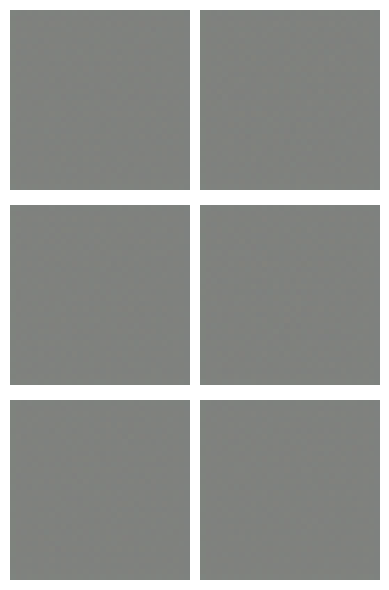

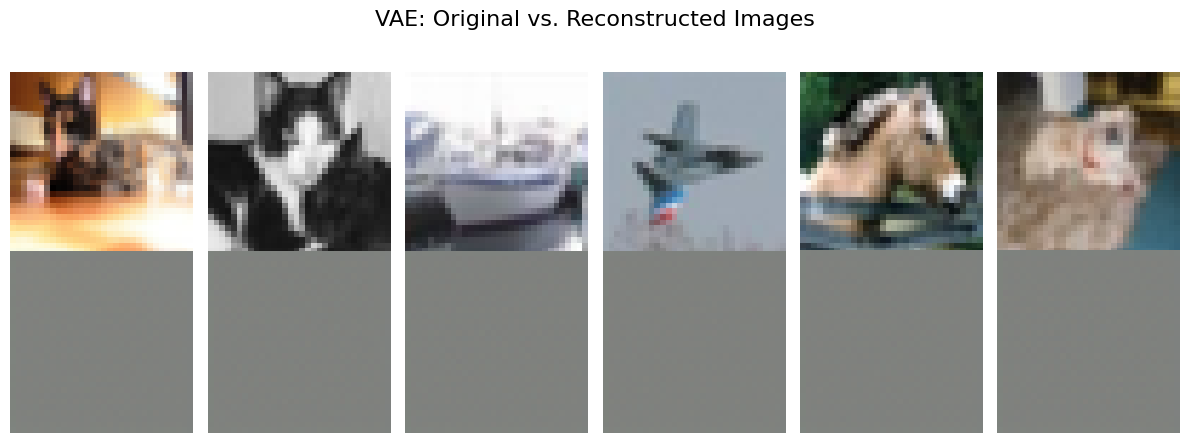

Epoch [1/30]  Loss: 212.6624 rec_Loss: 209.0715 kl_Loss: 3.5910


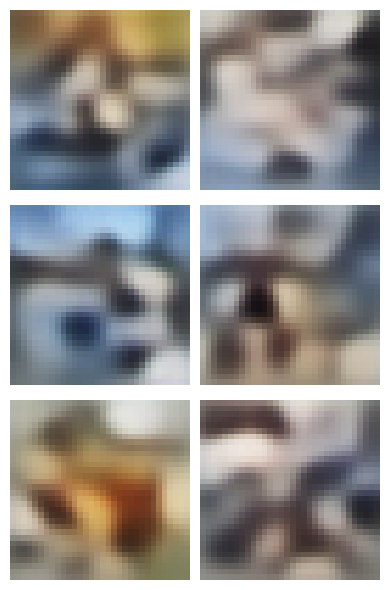

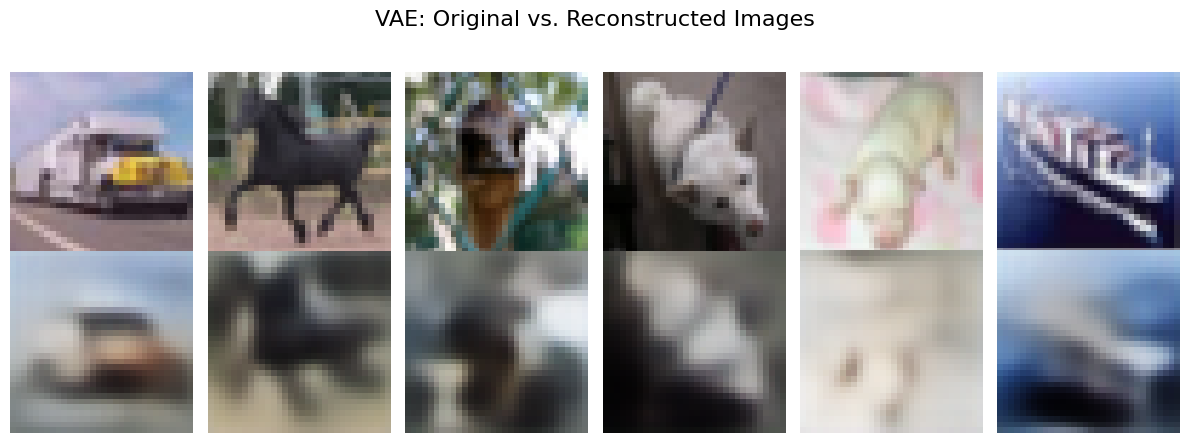

Epoch [2/30]  Loss: 106.6598 rec_Loss: 101.7191 kl_Loss: 4.9407
Epoch [3/30]  Loss: 101.3808 rec_Loss: 95.4452 kl_Loss: 5.9356
Epoch [4/30]  Loss: 100.3412 rec_Loss: 93.2263 kl_Loss: 7.1149
Epoch [5/30]  Loss: 99.9598 rec_Loss: 91.4549 kl_Loss: 8.5048
Epoch [6/30]  Loss: 100.5933 rec_Loss: 90.4431 kl_Loss: 10.1501


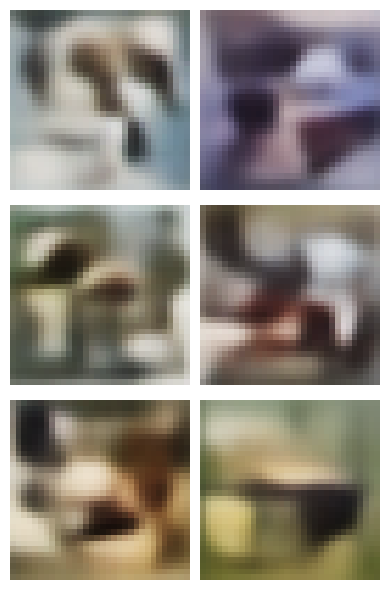

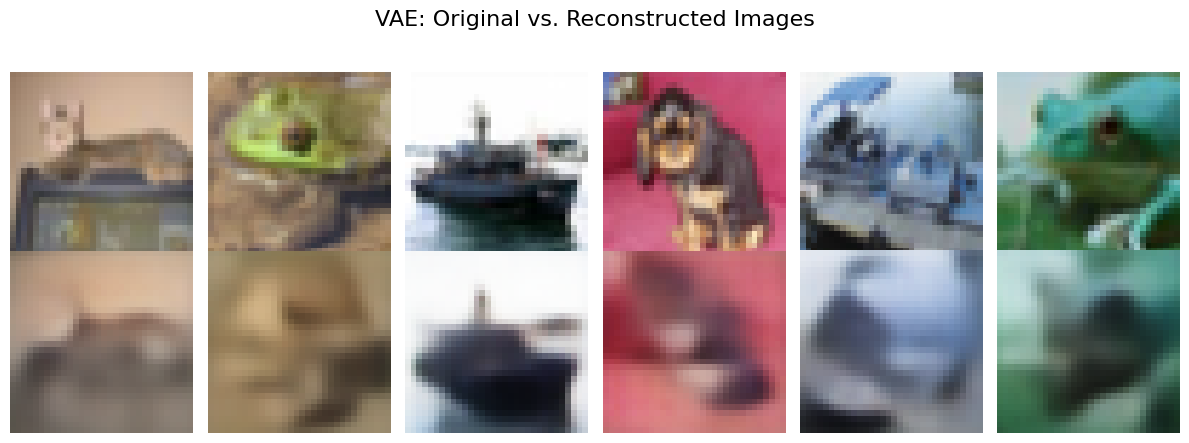

Epoch [7/30]  Loss: 101.6606 rec_Loss: 89.5699 kl_Loss: 12.0908
Epoch [8/30]  Loss: 103.6816 rec_Loss: 89.3239 kl_Loss: 14.3577
Epoch [9/30]  Loss: 105.7278 rec_Loss: 88.7544 kl_Loss: 16.9734
Epoch [10/30]  Loss: 108.3020 rec_Loss: 88.2552 kl_Loss: 20.0468
Epoch [11/30]  Loss: 112.2736 rec_Loss: 88.7439 kl_Loss: 23.5297


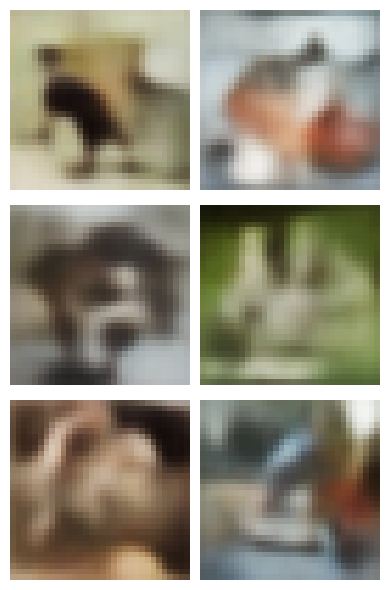

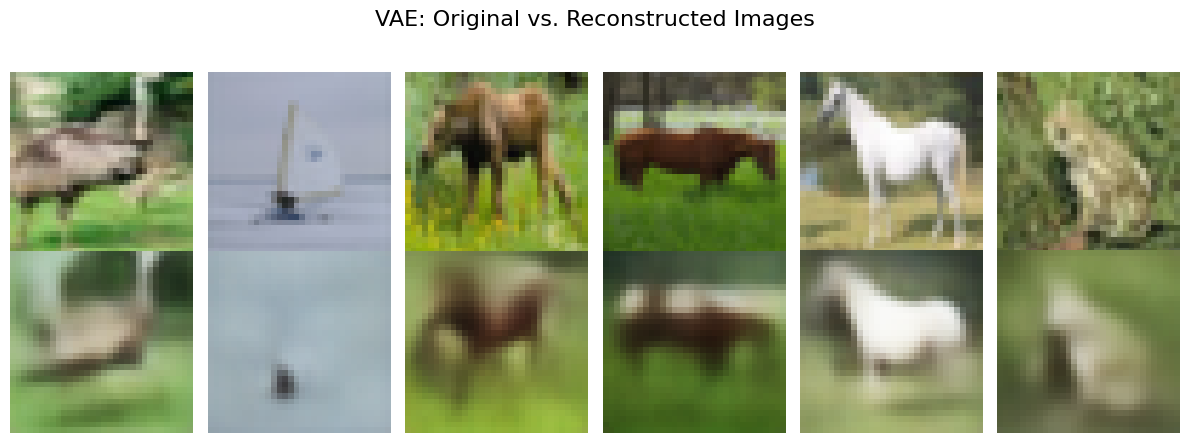

Epoch [12/30]  Loss: 116.7174 rec_Loss: 89.1350 kl_Loss: 27.5824
Epoch [13/30]  Loss: 122.1260 rec_Loss: 90.0155 kl_Loss: 32.1105
Epoch [14/30]  Loss: 128.8402 rec_Loss: 91.5898 kl_Loss: 37.2504
Epoch [15/30]  Loss: 131.3331 rec_Loss: 91.8180 kl_Loss: 39.5151
Epoch [16/30]  Loss: 130.1563 rec_Loss: 90.8640 kl_Loss: 39.2923


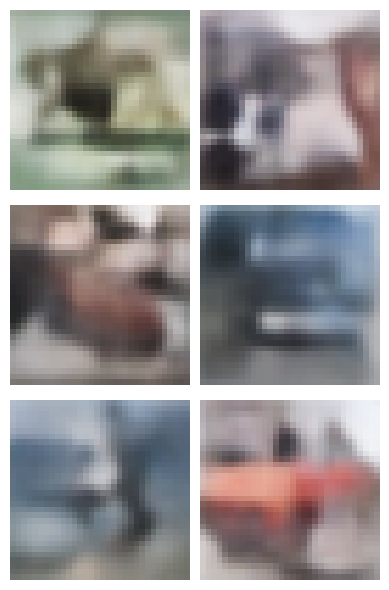

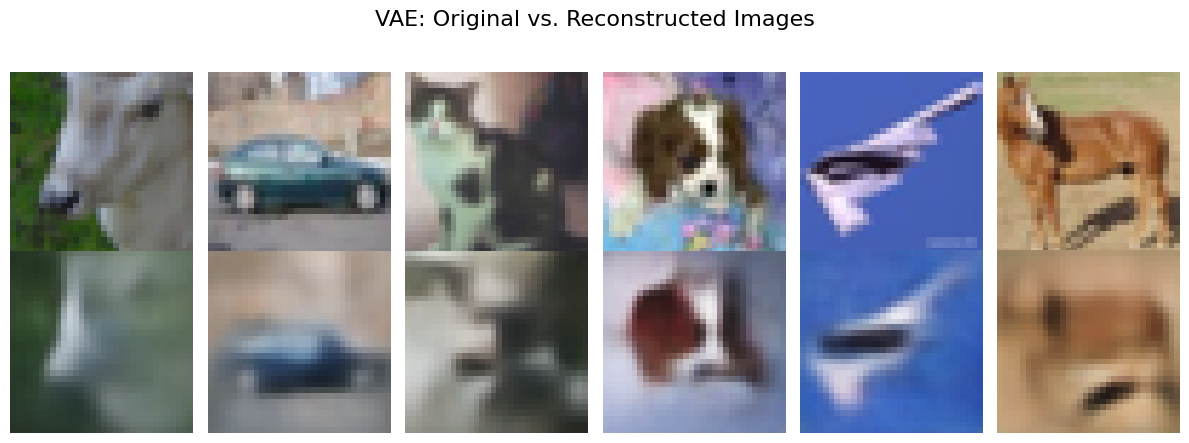

Epoch [17/30]  Loss: 128.8270 rec_Loss: 89.5899 kl_Loss: 39.2371
Epoch [18/30]  Loss: 127.7326 rec_Loss: 88.5271 kl_Loss: 39.2055
Epoch [19/30]  Loss: 126.2381 rec_Loss: 87.0479 kl_Loss: 39.1901
Epoch [20/30]  Loss: 125.3326 rec_Loss: 86.1530 kl_Loss: 39.1796
Epoch [21/30]  Loss: 124.1163 rec_Loss: 84.9092 kl_Loss: 39.2072


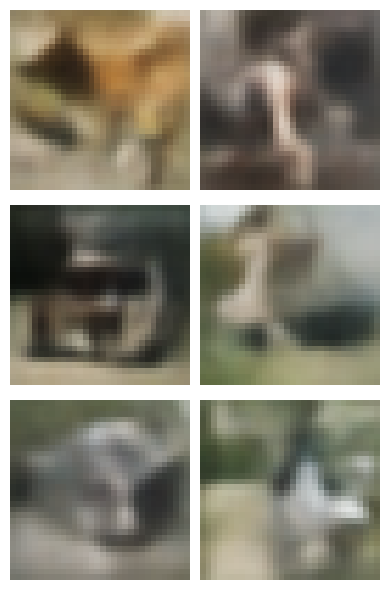

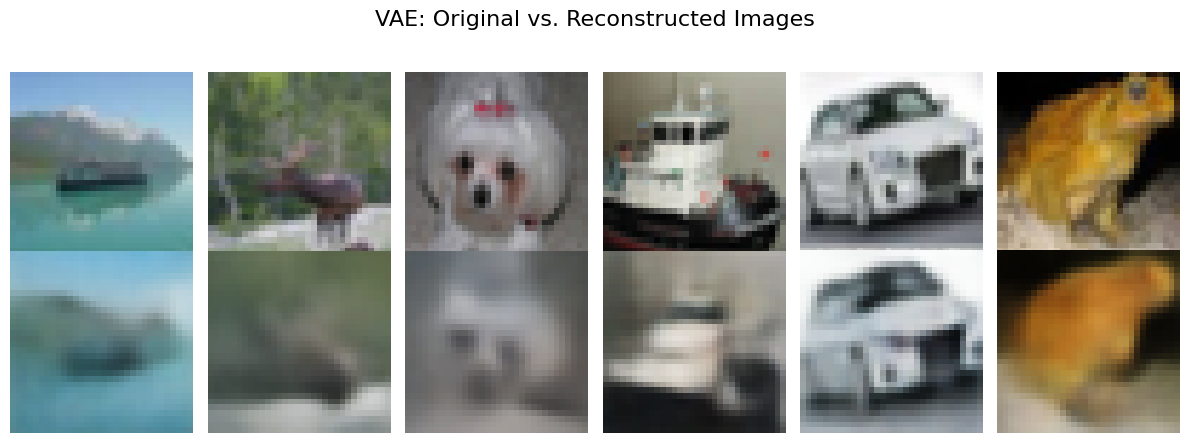

Epoch [22/30]  Loss: 122.9510 rec_Loss: 83.6960 kl_Loss: 39.2550
Epoch [23/30]  Loss: 121.9117 rec_Loss: 82.6384 kl_Loss: 39.2733
Epoch [24/30]  Loss: 120.9455 rec_Loss: 81.6359 kl_Loss: 39.3096
Epoch [25/30]  Loss: 120.0752 rec_Loss: 80.7213 kl_Loss: 39.3539
Epoch [26/30]  Loss: 119.3070 rec_Loss: 79.9017 kl_Loss: 39.4053


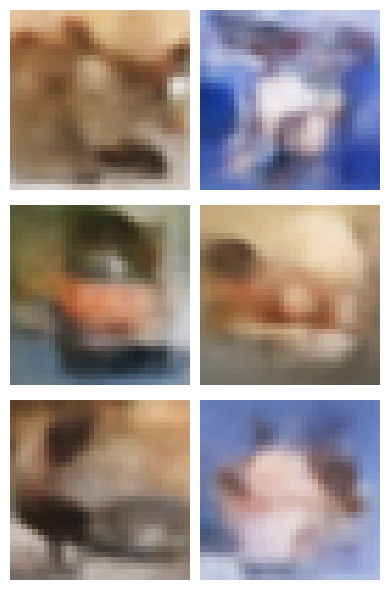

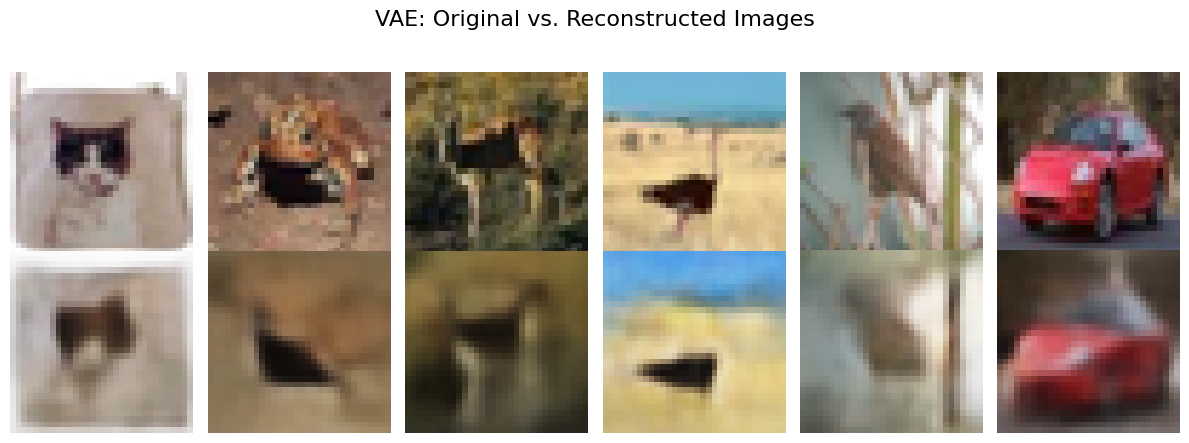

Epoch [27/30]  Loss: 118.1478 rec_Loss: 78.7143 kl_Loss: 39.4334
Epoch [28/30]  Loss: 117.5143 rec_Loss: 78.0169 kl_Loss: 39.4974
Epoch [29/30]  Loss: 116.7139 rec_Loss: 77.1877 kl_Loss: 39.5262
Epoch [30/30]  Loss: 115.7859 rec_Loss: 76.2163 kl_Loss: 39.5696


In [63]:
betas = [(0.02,0.4)]
v_loses = []
rec_losses = []
k_losses = []
models = []
for i in betas:
    vae =  VAE(64).to(device)
    generate_and_plot_vae(vae.decoder,64,6)
    generate_and_plot_vae_recon(vae,next(iter(train_loader))[0],6)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    vae_losses = []
    recon_losses = []
    kl_losses = []
    epochs = 30
    beta = i[0]

    for epoch in range(epochs):
        epoch_loss = 0
        recon_loss_epoch = 0
        kl_loss_epoch = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            recon,mu,logvar = vae(imgs)
            loss,recon_loss,kl_loss = vae_loss(recon, imgs, mu, logvar,beta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
            recon_loss_epoch += recon_loss.item()
            kl_loss_epoch += kl_loss.item()
            #print(f"loss: {loss.item()} kl_loss {kl_loss.item()} recon_loss {recon_loss.item()}")
        avg_loss = epoch_loss / len(train_loader)
        avg_loss_recon = recon_loss_epoch / len(train_loader)
        avg_loss_kl = kl_loss_epoch/len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f} rec_Loss: {avg_loss_recon:.4f} kl_Loss: {avg_loss_kl:.4f}")
        vae_losses.append(avg_loss)
        beta = 1.25 * beta
        if beta > i[1]:
            beta = i[1]
        if epoch % 5 == 0:
            generate_and_plot_vae(vae.decoder,64,6)
            generate_and_plot_vae_recon(vae,next(iter(train_loader))[0],6)
            path = f"model_vae_{i[1]}.pth"
            models.append(vae.decoder)
            torch.save(vae.state_dict(),path)
    v_loses.append(vae_losses)
    rec_losses.append(recon_losses)
    k_losses.append(kl_losses)

Epoch [1/20]  Loss: 125.0103 rec_Loss: 79.0884 kl_Loss: 45.9219


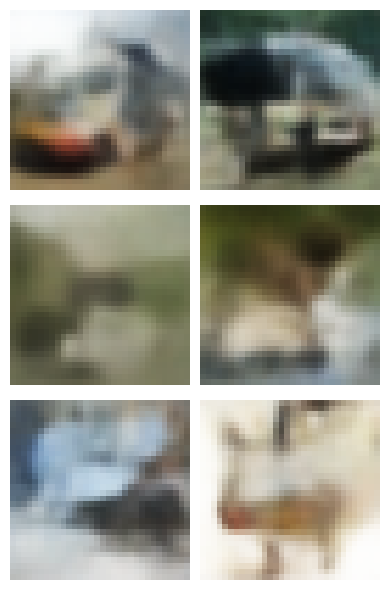

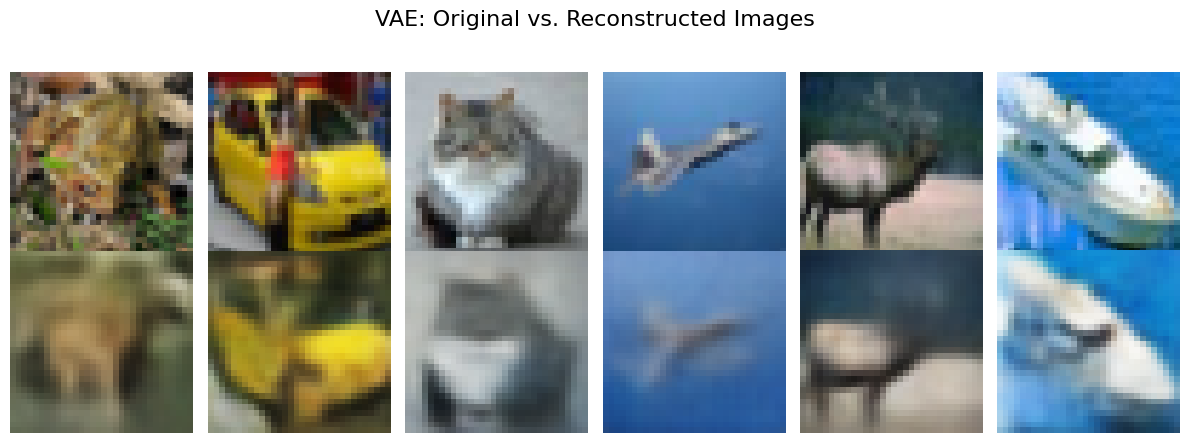

Epoch [2/20]  Loss: 124.3714 rec_Loss: 78.4536 kl_Loss: 45.9178
Epoch [3/20]  Loss: 124.1252 rec_Loss: 78.2141 kl_Loss: 45.9111
Epoch [4/20]  Loss: 123.3731 rec_Loss: 77.4534 kl_Loss: 45.9197
Epoch [5/20]  Loss: 122.7732 rec_Loss: 76.8685 kl_Loss: 45.9047
Epoch [6/20]  Loss: 122.0541 rec_Loss: 76.1331 kl_Loss: 45.9209


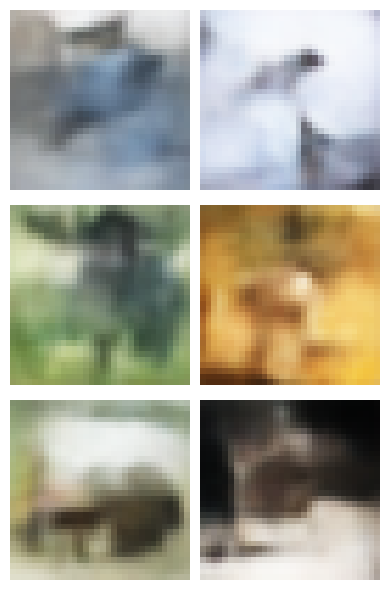

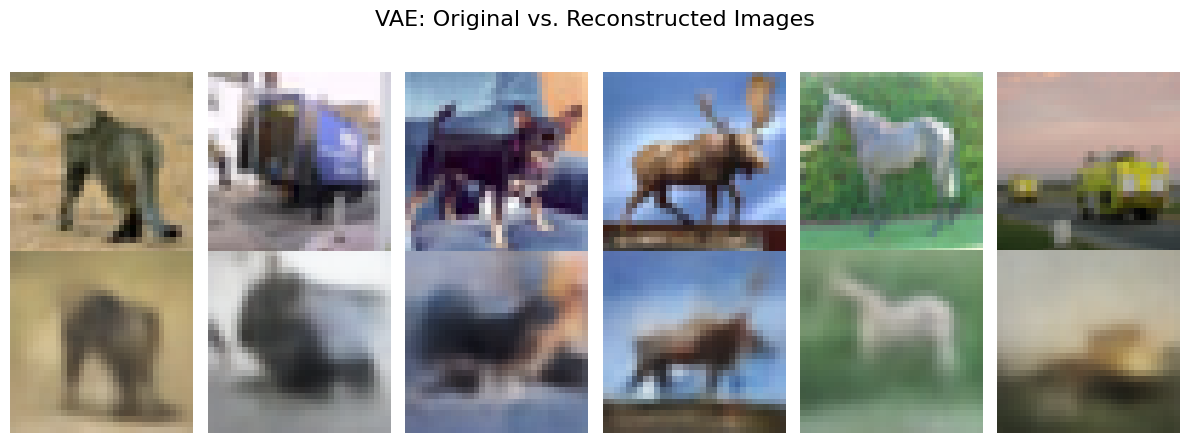

Epoch [7/20]  Loss: 121.7280 rec_Loss: 75.7836 kl_Loss: 45.9444
Epoch [8/20]  Loss: 121.3533 rec_Loss: 75.3981 kl_Loss: 45.9552
Epoch [9/20]  Loss: 120.8056 rec_Loss: 74.8428 kl_Loss: 45.9629
Epoch [10/20]  Loss: 120.2493 rec_Loss: 74.2143 kl_Loss: 46.0349
Epoch [11/20]  Loss: 119.8650 rec_Loss: 73.7793 kl_Loss: 46.0857


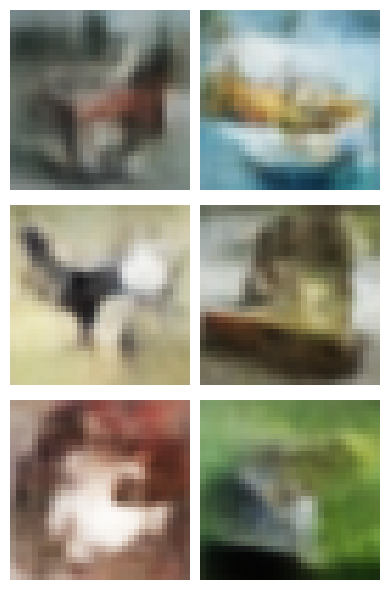

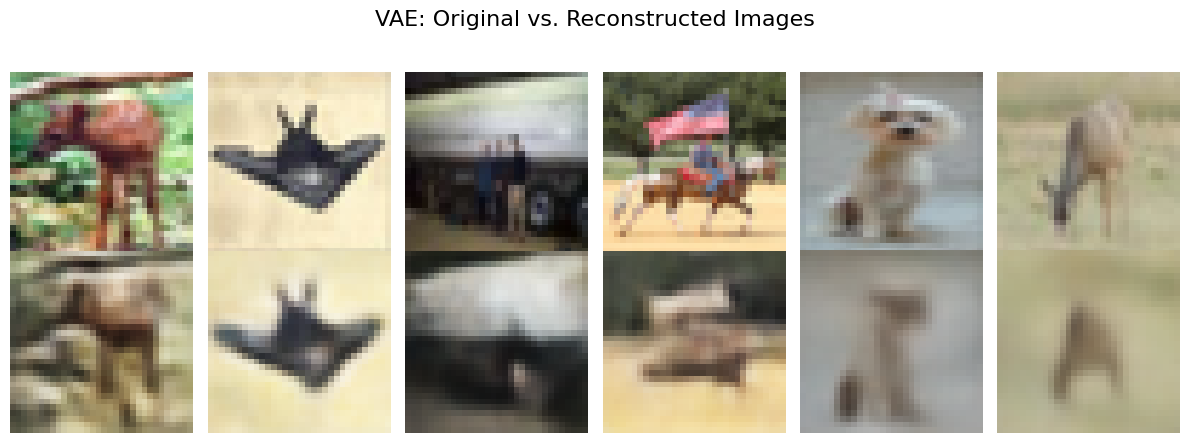

Epoch [12/20]  Loss: 119.3630 rec_Loss: 73.2940 kl_Loss: 46.0690
Epoch [13/20]  Loss: 118.5490 rec_Loss: 72.4341 kl_Loss: 46.1150
Epoch [14/20]  Loss: 118.5046 rec_Loss: 72.3846 kl_Loss: 46.1201
Epoch [15/20]  Loss: 117.9544 rec_Loss: 71.8098 kl_Loss: 46.1446
Epoch [16/20]  Loss: 117.6157 rec_Loss: 71.4708 kl_Loss: 46.1449


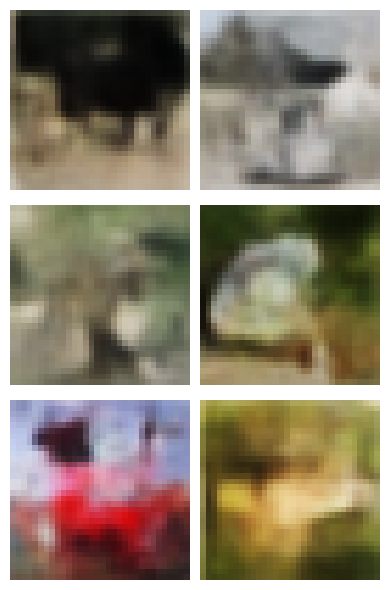

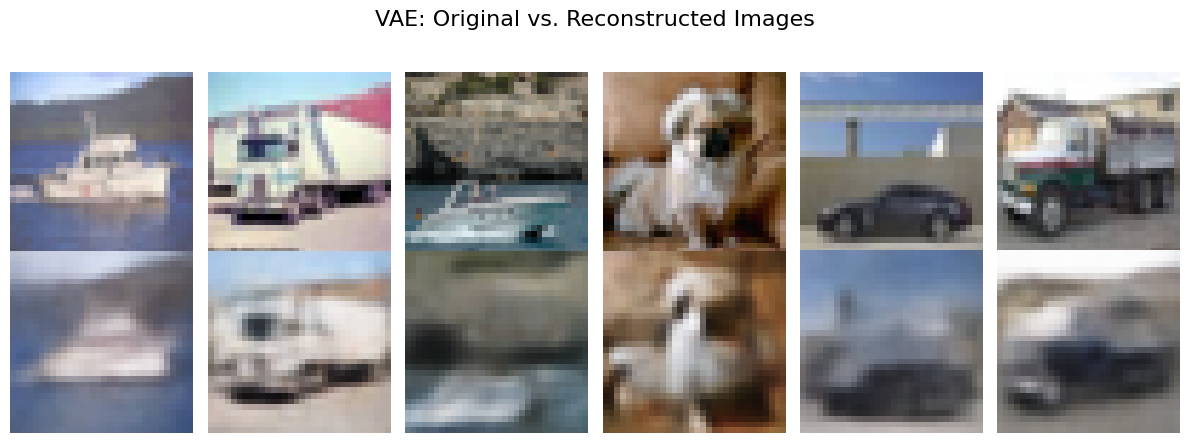

Epoch [17/20]  Loss: 117.3301 rec_Loss: 71.1715 kl_Loss: 46.1586
Epoch [18/20]  Loss: 116.8372 rec_Loss: 70.6558 kl_Loss: 46.1814
Epoch [19/20]  Loss: 116.6745 rec_Loss: 70.4585 kl_Loss: 46.2159
Epoch [20/20]  Loss: 116.2595 rec_Loss: 70.0301 kl_Loss: 46.2294


In [75]:
betas = [(0.5,0.5)]
for i in betas:
    epochs = 20
    beta = i[0]

    for epoch in range(epochs):
        epoch_loss = 0
        recon_loss_epoch = 0
        kl_loss_epoch = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            recon,mu,logvar = vae(imgs)
            loss,recon_loss,kl_loss = vae_loss(recon, imgs, mu, logvar,beta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
            recon_loss_epoch += recon_loss.item()
            kl_loss_epoch += kl_loss.item()
            #print(f"loss: {loss.item()} kl_loss {kl_loss.item()} recon_loss {recon_loss.item()}")
        avg_loss = epoch_loss / len(train_loader)
        avg_loss_recon = recon_loss_epoch / len(train_loader)
        avg_loss_kl = kl_loss_epoch/len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f} rec_Loss: {avg_loss_recon:.4f} kl_Loss: {avg_loss_kl:.4f}")
        vae_losses.append(avg_loss)
        beta = 1.25 * beta
        if beta > i[1]:
            beta = i[1]
        if epoch % 5 == 0:
            generate_and_plot_vae(vae.decoder,64,6)
            generate_and_plot_vae_recon(vae,next(iter(train_loader))[0],6)
            path = f"model_vae_{i[1]}.pth"
            models.append(vae.decoder)
            torch.save(vae.state_dict(),path)
    v_loses.append(vae_losses)
    rec_losses.append(recon_losses)
    k_losses.append(kl_losses)

Text(0, 0.5, 'vae-loss mse based')

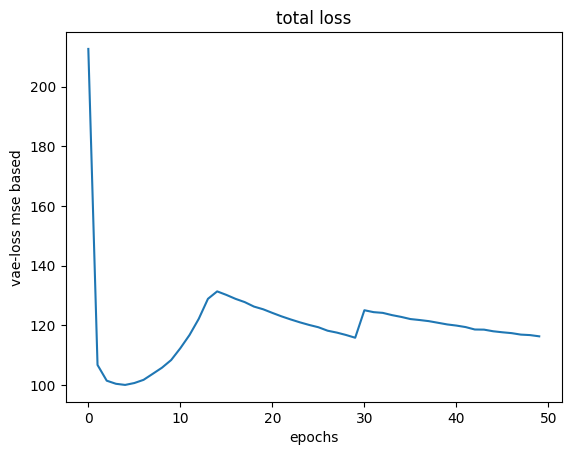

In [147]:
plt.plot(vae_losses, label= "total_loss")
plt.title("total loss")
plt.xlabel("epochs")
plt.ylabel("vae-loss mse based")

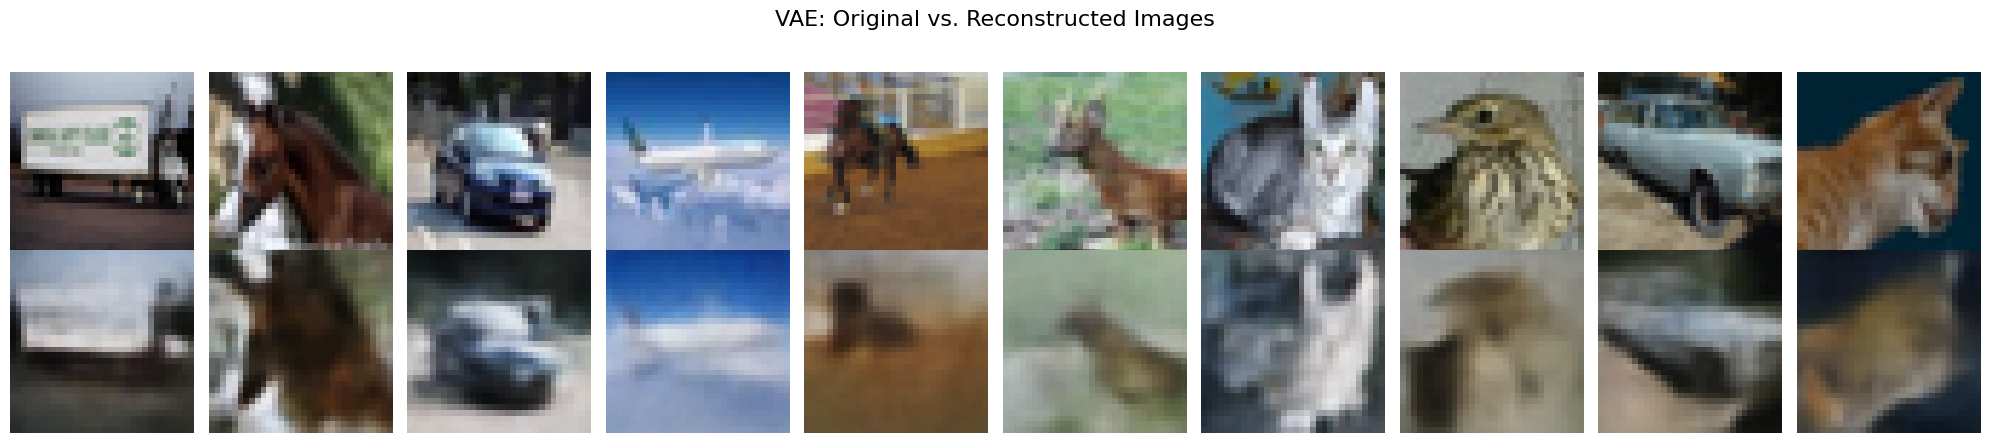

In [76]:
generate_and_plot_vae_recon(vae,next(iter(train_loader))[0],10)

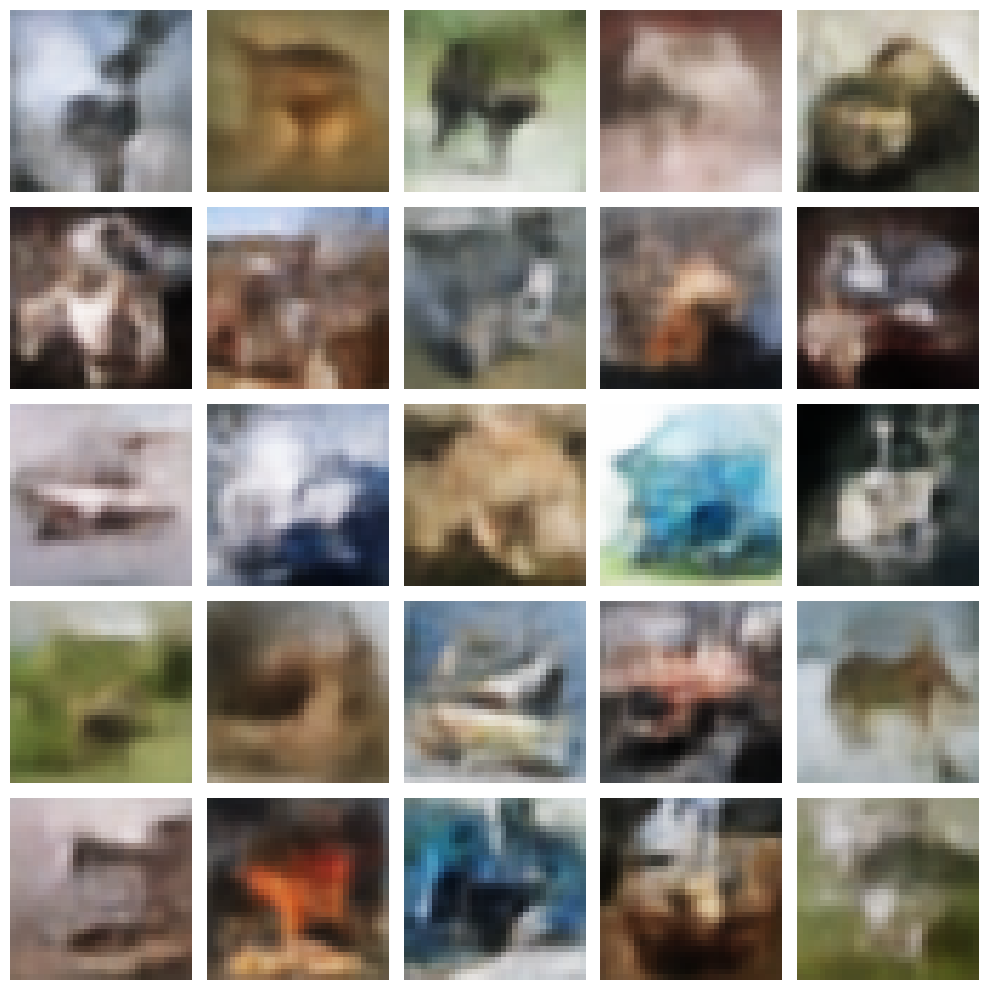

In [77]:
generate_and_plot_vae(vae.decoder,64,25)

In [107]:
import random
img,label = next(iter(train_loader))
while True:
    ind1 = random.randint(0,63)
    ind2 = random.randint(0,63)
    if label[ind1] != label[ind2]:
        break

torch.Size([3, 32, 32])


Text(0.5, 1.0, 'tensor(1)')

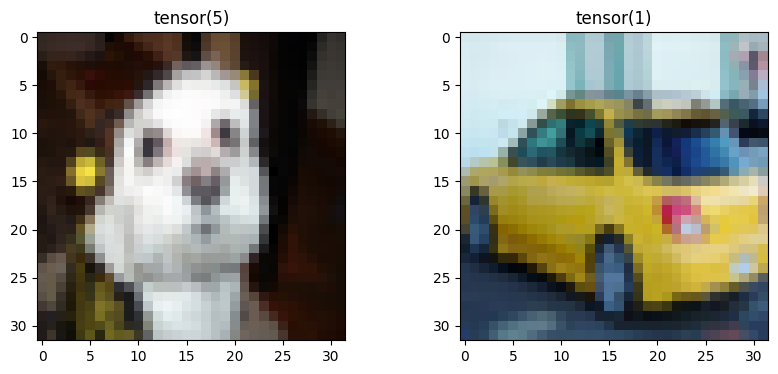

In [108]:
print(img[ind1].shape)
img1 = img[ind1].permute(1,2,0).numpy()
img2 = img[ind2].permute(1,2,0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
axs[0].imshow((img1+1)/2)
axs[0].set_title(label[ind1])

axs[1].imshow((img2+1)/2)
axs[1].set_title(label[ind2])


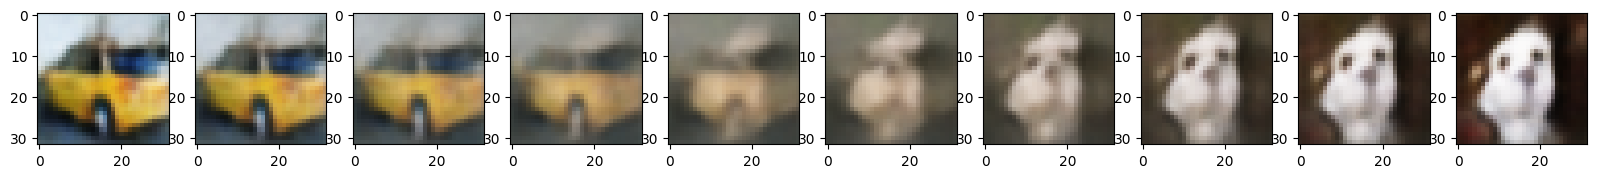

In [148]:
def interpolate(img1,img2,vae_model,steps):
    img1 = torch.tensor(img1).permute(2,0,1).unsqueeze(0).float().to(device)
    img2 = torch.tensor(img2).permute(2,0,1).unsqueeze(0).float().to(device)
    mu,logvar = vae_model.encoder(img1)
    z1 = vae_model.reparameterize(mu,logvar)

    mu,logvar = vae_model.encoder(img2)
    z2 = vae_model.reparameterize(mu,logvar)
    fig, axs = plt.subplots(1, steps, figsize=(20, 20)) 
    for i in range(steps):
        c1 = (i)/(steps-1)
        c2 = 1 - c1
        z = c1*z1 + c2*z2
        recon = vae_model.decoder(z)
        recon = recon[0].permute(1,2,0).cpu().detach().numpy()
        axs[i].imshow((recon+1)/2)

interpolate(img1,img2,vae,10)

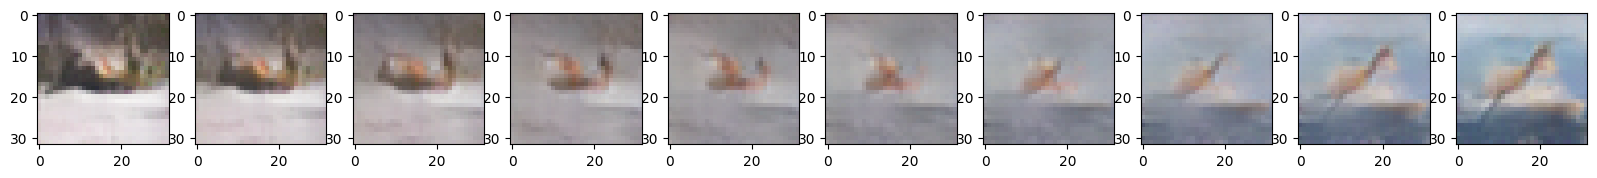

In [118]:
def interpolate_gan(Gen,z_dim):
    z1 = torch.randn(1,z_dim,1,1).to(device)
    z2 = torch.randn(1,z_dim,1,1).to(device)
    steps = 10
    fig, axs = plt.subplots(1, steps, figsize=(20, 20)) 
    for i in range(steps):
        c1 = (i)/(steps-1)
        c2 = 1 - c1
        z = c1*z1 + c2*z2
        recon = Gen(z)
        recon = recon[0].permute(1,2,0).cpu().detach().numpy()
        axs[i].imshow((recon+1)/2)

interpolate_gan(Gen,100)

In [133]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_latent_dimension_variation(
    input_img, 
    vae_model, 
    num_dims_to_explore=10, 
    num_steps=9, 
    variation_range=(-3, 3)
):
    vae_model.eval()
    device = next(vae_model.parameters()).device

    # --- 1. Encode the original image to get its "ground truth" latent vector ---
    with torch.no_grad():
        # Preprocess the image to match model's expected input (B, C, H, W)
        img_tensor = torch.tensor(input_img).permute(2, 0, 1).unsqueeze(0).float().to(device)
        
        # We use the mean (mu) as the stable latent representation
        mu, logvar = vae_model.encoder(img_tensor)
        z_original = mu

    # --- 2. Select random dimensions to explore ---
    latent_dim_size = z_original.shape[1]
    if num_dims_to_explore > latent_dim_size:
        print(f"Warning: Requesting to explore {num_dims_to_explore} dimensions, but latent space size is only {latent_dim_size}.")
        num_dims_to_explore = latent_dim_size
        
    # Choose unique dimensions and sort them for a cleaner plot
    chosen_dims = np.sort(np.random.choice(latent_dim_size, num_dims_to_explore, replace=False))
    
    # --- 3. Prepare the plot ---
    fig, axs = plt.subplots(num_dims_to_explore, num_steps, figsize=(num_steps * 1.5, num_dims_to_explore * 1.5))
    fig.suptitle('Variation of Individual Latent Dimensions', fontsize=16)

    # --- 4. Iterate, generate, and plot ---
    with torch.no_grad():
        for row_idx, dim_to_vary in enumerate(chosen_dims):
            # Create the range of values to sweep for the current dimension
            variation_values = np.linspace(variation_range[0], variation_range[1], num_steps)
            
            for col_idx, value in enumerate(variation_values):
                # Create a copy of the original latent vector
                z_modified = z_original.clone()
                
                # Overwrite the value of the dimension we are currently exploring
                z_modified[0, dim_to_vary] = value
                
                # Decode the modified latent vector
                recon_tensor = vae_model.decoder(z_modified)
                
                # Post-process for plotting
                recon_img = recon_tensor[0].permute(1, 2, 0).cpu().numpy()
                
                # Plot the image
                ax = axs[row_idx, col_idx]
                ax.imshow((recon_img + 1) / 2) # Denormalize from [-1, 1] to [0, 1]
                ax.axis('off')
                
                # Label the row with the dimension index
                if col_idx == 0:
                    ax.set_title(f'Dim: {dim_to_vary}', fontsize=8, loc='left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

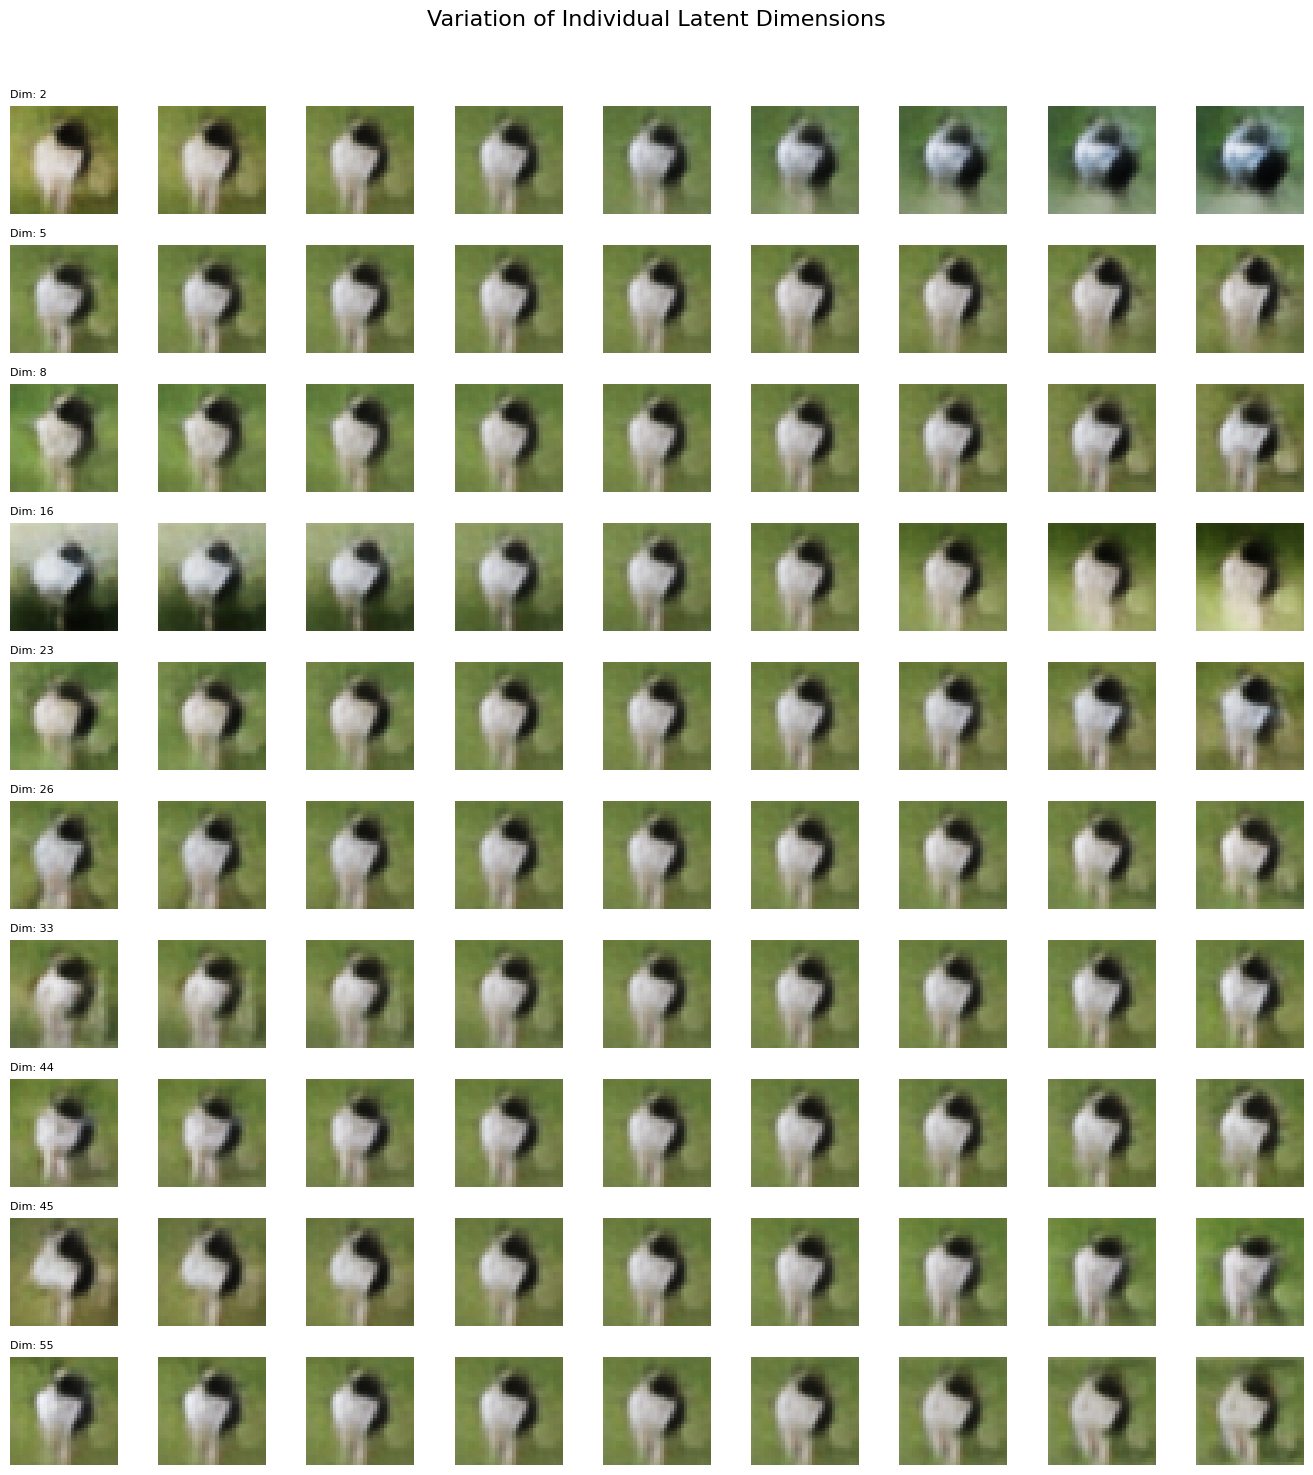

In [137]:
import random
num = random.randint(0,63)
img_tensor = next(iter(train_loader))[0][num]
img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()
visualize_latent_dimension_variation(img_numpy, vae, 10, 9)

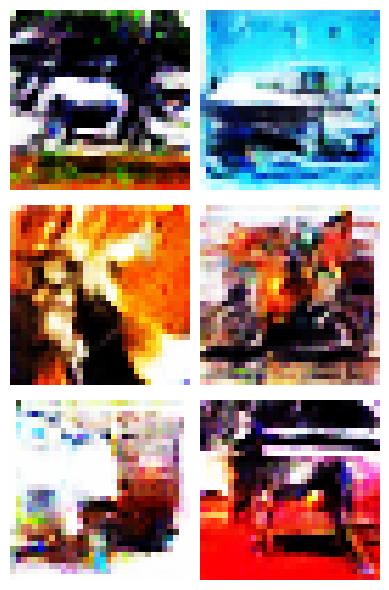

NameError: name 'generate_and_plot' is not defined

In [ ]:
generate_and_plot_ood(Gen,100,6)
generate_and_plot(Gen,100,6)

In [ ]:
new_dataset = torchvision.datasets.CIFAR100(root = "./data",train=False,download=True, transform=vae_transform)
new_data_loader = torch.utils.data.DataLoader(new_dataset,batch_size,shuffle=False)

t_loss = 0
t_r = 0
t_kl = 0
true_losses = []
artificial_losses = []
for img,_ in train_loader:
    img = img.to(device)
    recon,mu,logvar = vae(img)
    loss,recon_loss,kl_loss = vae_loss(recon,img,mu,logvar,1)
    t_loss += loss.item()
    true_losses.append(loss.item())
    t_r += recon_loss.item()
    t_kl += kl_loss.item()

print("total_loss: ",t_loss/len(train_loader)," recon_loss: ", t_r/len(train_loader)," kl_loss: ",t_kl/len(train_loader))

t_loss2 = 0
t_r2 = 0
t_kl2 = 0
for img,_ in new_data_loader:
    img = img.to(device)
    recon,mu,logvar = vae(img)
    loss,recon_loss,kl_loss = vae_loss(recon,img,mu,logvar,1)
    artificial_losses.append(loss.item())
    t_loss2 += loss.item()
    t_r2 += recon_loss.item()
    t_kl2 += kl_loss.item()

print("total_loss: ",t_loss/len(new_data_loader)," recon_loss: ", t_r/len(new_data_loader)," kl_loss: ",t_kl/len(new_data_loader))

AttributeError: 'float' object has no attribute 'numpy'

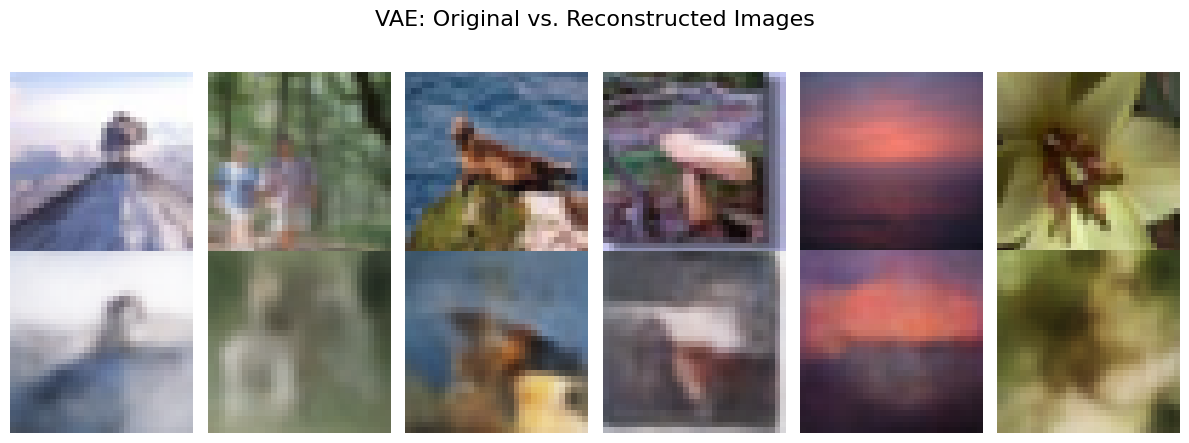

In [101]:
generate_and_plot_vae_recon(vae,next(iter(new_data_loader))[0],6)

In [150]:
imgs10,_ = next(iter(train_loader))
imgs100,_ = next(iter(train_loader))
print(imgs10.shape)
print(imgs100.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])


In [151]:
num = 0
loses_original = []
for i in imgs10:
    i = i.to(device)
    i = i.unsqueeze(0).float().to(device)
    recon,mu,logvar = vae(i)
    _,loss,_ = vae_loss(recon,i,mu,logvar,1)
    if loss.item() < 250:
        num += 1
    loses_original.append(loss.item())
    #print(loss.item(), "cifar_10")
#print(num)

In [ ]:
num = 0
artificial_losses = []
for i in imgs100:
    i = i.to(device)
    i = i.unsqueeze(0).float().to(device)
    recon,mu,logvar = vae(i)
    if loss.item() < 250:
        num += 1
    _,loss,_ = vae_loss(recon,i,mu,logvar,1)
    artificial_losses.append(loss)

110.84939575195312 cifar_100
52.68580627441406 cifar_100
58.4144401550293 cifar_100
55.24602127075195 cifar_100
75.67465209960938 cifar_100
76.3753662109375 cifar_100
101.66960144042969 cifar_100
57.041168212890625 cifar_100
108.74901580810547 cifar_100
116.70960998535156 cifar_100
56.90315246582031 cifar_100
127.46831512451172 cifar_100
97.26945495605469 cifar_100
30.989259719848633 cifar_100
50.464134216308594 cifar_100
129.6748046875 cifar_100
64.42504119873047 cifar_100
56.19004440307617 cifar_100
72.192138671875 cifar_100
73.92369079589844 cifar_100
60.02555847167969 cifar_100
49.391109466552734 cifar_100
73.79034423828125 cifar_100
89.87422180175781 cifar_100
55.13850784301758 cifar_100
64.72781372070312 cifar_100
98.40586853027344 cifar_100
34.27410888671875 cifar_100
97.79869842529297 cifar_100
99.20532989501953 cifar_100
62.368408203125 cifar_100
40.32939529418945 cifar_100
80.88505554199219 cifar_100
78.25830078125 cifar_100
74.42318725585938 cifar_100
66.23661041259766 cifar

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

def generate_and_plot_ood(generator, z_dim, num_images=6, device='cuda'):
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        # Generate noise for all images
        z = torch.randn(num_images, z_dim,1,1) * 5
        z = z.to(device)
        fake_images = generator(z).cpu()  # [B, C, H, W]

        # Rescale from [-1,1] to [0,1] if using Tanh output
        fake_images = (fake_images + 1) / 2

    # Determine grid size
    grid_cols = int(math.sqrt(num_images))
    grid_rows = (num_images + grid_cols - 1) // grid_cols

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
    axes = axes.flatten()

    for i in range(num_images):
        img = fake_images[i].permute(1, 2, 0).numpy()  # [H,W,C]
        axes[i].imshow(img)
        axes[i].axis('off')

    # Turn off any unused axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# generate_and_plot(Gen, z_dim=128, num_images=16, device=device)

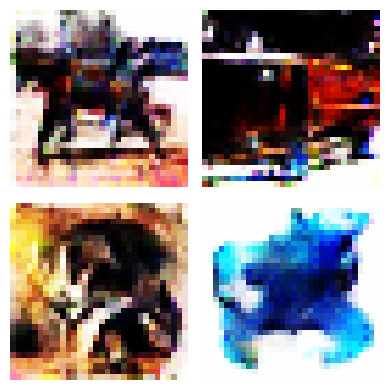

NameError: name 'generate_and_plot' is not defined

In [138]:
generate_and_plot_ood(Gen,100,4)
generate_and_plot(Gen,100,6)

In [86]:
def denormalise(imgs):
    mean = torch.tensor([0.4914, 0.4822, 0.4465], device=imgs.device).view(1, 3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616], device=imgs.device).view(1, 3, 1, 1)
    imgs = imgs * std + mean
    return torch.clamp(imgs, 0, 1)

In [87]:
image_size = 299
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()   # NO Normalize here!
])


test_dataset = torchvision.datasets.CIFAR10(root = "./data", train=False, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size,shuffle = False)


In [88]:
img,_ = next(iter(test_dataloader))
print(img.shape)

torch.Size([64, 3, 299, 299])


In [89]:
print(len(test_dataloader))

157


In [15]:
import torch

torch.cuda.empty_cache()

In [124]:
from torchmetrics.image.inception import InceptionScore
from torchvision.models import inception_v3
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
Gen.to(device)
Gen.eval()
IS = InceptionScore().to(device)
Inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
fid = FrechetInceptionDistance(feature=2048).to(device)
z_dim = 100
num_imgs = 10000
gan_preds = []
Inception_model.eval()
for i in range(num_imgs // batch_size):
    z = torch.randn(batch_size,z_dim,1,1,device=device) * 5
    gan_img = Gen(z)
    gan_img = denormalise(gan_img)
    gan_imgs = F.interpolate(gan_img, size=(image_size, image_size), mode="bilinear", align_corners=False)
    imgs = (gan_imgs * 255).to(torch.uint8)  
    IS.update(imgs)
    fid.update(imgs,real=False)
    with torch.no_grad():
        logits = Inception_model(gan_imgs)
        probabilities = F.softmax(logits, dim=1).cpu().detach().numpy()
        gan_preds.append(probabilities)
IS_mean, IS_std = IS.compute()
for img,_ in test_dataloader:
    img = img.to(device)
    img = (img * 255).to(torch.uint8)  
    fid.update(img,real=True)
fid_score = fid.compute()
print(f"inception score {IS_mean} +- {IS_std}")
print(f"fid_score = {fid_score}")
gan_preds = np.concatenate(gan_preds,axis = 0)
print(gan_preds.shape)
marginal_p_y = np.mean(gan_preds, axis=0)


entropy = -np.sum(marginal_p_y * np.log(marginal_p_y + 1e-9))
print(f"Entropy of marginal distribution : {entropy:.4f}")

/home/sarfraz/atml/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/sarfraz/atml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sarfraz/atml/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


inception score 5.192805290222168 +- 0.11267733573913574
fid_score = 90.75093841552734
(9984, 1000)
Entropy of marginal distribution : 5.9129


In [ ]:
from torchmetrics.image.inception import InceptionScore
from torchvision.models import inception_v3
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
import torchvision.transforms as T
Gen.to(device)
Gen.eval()
IS = InceptionScore().to(device)
Inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
fid = FrechetInceptionDistance(feature=2048).to(device)
inception_normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
z_dim = 100
num_imgs = 10000
gan_preds = []
Inception_model.eval()
for i in range(num_imgs // batch_size):
    z = torch.randn(batch_size,z_dim,1,1,device=device)
    gan_img = Gen(z)
    gan_img = denormalise(gan_img)
    gan_imgs = F.interpolate(gan_img, size=(image_size, image_size), mode="bilinear", align_corners=False)
    imgs = (gan_imgs * 255).to(torch.uint8)  
    IS.update(imgs)
    fid.update(imgs,real=False)
    with torch.no_grad():
        logits = Inception_model(gan_imgs)
        probabilities = F.softmax(logits, dim=1).cpu().detach().numpy()
        gan_preds.append(probabilities)
IS_mean, IS_std = IS.compute()
for img,_ in test_dataloader:
    img = img.to(device)
    img = (img * 255).to(torch.uint8)  
    fid.update(img,real=True)
fid_score = fid.compute()
print(f"inception score {IS_mean} +- {IS_std}")
print(f"fid_score = {fid_score}")
gan_preds = np.concatenate(gan_preds,axis = 0)
print(gan_preds.shape)
marginal_p_y = np.mean(gan_preds, axis=0)


entropy = -np.sum(marginal_p_y * np.log(marginal_p_y + 1e-9))
print(f"Entropy of marginal distribution : {entropy:.4f}")

inception score 5.959176540374756 +- 0.11240864545106888
fid_score = 42.29866409301758
(9984, 1000)
Entropy of marginal distribution : 5.9456


In [ ]:
gan_preds = np.concatenate(gan_preds,axis = 0)
print(gan_preds.shape)


In [131]:
from torchmetrics.image.inception import InceptionScore
#state_dict = torch.load("vae",map_location="cpu")
#Gen.load_state_dict(state_dict)
#Gen.to(device)
vae_preds = []
vae.eval()
fid = FrechetInceptionDistance(feature=2048).to(device)
IS = InceptionScore().to(device)
z_dim = 64
num_imgs = 10000
inception_normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
for _ in range(num_imgs // batch_size):
    z = torch.randn(batch_size,z_dim,device=device)
    vae_img = vae.decoder(z)
    vae_imgs = F.interpolate(vae_img, size=(image_size, image_size), mode="bilinear", align_corners=False)
    imgs = (vae_imgs * 255).to(torch.uint8)  
    IS.update(imgs)
    fid.update(imgs,real = False)
    with torch.no_grad():
        #vae_imgs = inception_normalize(vae_imgs)
        logits = Inception_model(vae_imgs)
        probabilities = F.softmax(logits, dim=1).cpu().detach().numpy()
        vae_preds.append(probabilities)
    
for img,_ in test_dataloader:
    img = img.to(device)
    img = (img * 255).to(torch.uint8)
    fid.update(img,real=True)
IS_mean, IS_std = IS.compute()
fid_score = fid.compute()
print(f"inception score {IS_mean} +- {IS_std}")
print(f"fid_score {fid_score}")

vae_preds = np.concatenate(vae_preds,axis = 0)
print(vae_preds.shape)
marginal_p_y_vae = np.mean(vae_preds, axis=0)


entropy = -np.sum(marginal_p_y_vae * np.log(marginal_p_y_vae + 1e-9))
print(f"Entropy of marginal distribution : {entropy:.4f}")

/home/sarfraz/atml/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


inception score 1.867645502090454 +- 0.0352972187101841
fid_score 281.0336608886719
(9984, 1000)
Entropy of marginal distribution : 5.4451


In [ ]:
from torchmetrics.image.inception import InceptionScore
#state_dict = torch.load("vae",map_location="cpu")
#Gen.load_state_dict(state_dict)
#Gen.to(device)
vae_preds = []
vae.eval()
fid = FrechetInceptionDistance(feature=2048).to(device)
IS = InceptionScore().to(device)
z_dim = 64
num_imgs = 10000
inception_normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for img,_ in train_loader:
    img = img.to(device)
    vae_img,_,_ = vae(img)
    fake_vae_imgs = F.interpolate(vae_img, size=(image_size, image_size), mode="bilinear", align_corners=False)
    fake_imgs = (fake_vae_imgs * 255).to(torch.uint8)

    real_vae_imgs = F.interpolate(img, size=(image_size, image_size), mode="bilinear", align_corners=False)  
    real_vae_imgs = (real_vae_imgs*255).to(torch.uint8)
    fid.update(real_vae_imgs,real=True)


    IS.update(fake_imgs)
    fid.update(fake_imgs,real = False)
    with torch.no_grad():
        logits = Inception_model(fake_vae_imgs)
        probabilities = F.softmax(logits, dim=1).cpu().detach().numpy()
        vae_preds.append(probabilities)

IS_mean, IS_std = IS.compute()
fid_score = fid.compute()
print(f"inception score {IS_mean} +- {IS_std}")
print(f"fid_score {fid_score}")

vae_preds = np.concatenate(vae_preds,axis = 0)
print(vae_preds.shape)
marginal_p_y_vae = np.mean(vae_preds, axis=0)


entropy = -np.sum(marginal_p_y_vae * np.log(marginal_p_y_vae + 1e-9))
print(f"Entropy of marginal distribution : {entropy:.4f}")

KeyboardInterrupt: 

In [128]:
from sklearn.manifold import TSNE
import numpy as np

latents = []
labels = []
vae.eval()
with torch.no_grad():
    for images,label in train_loader:
        images = images.to(device)
        mu,logvar = vae.encoder(images)
        z = vae.reparameterize(mu,logvar)
        latents.append(z.cpu().numpy())
        labels.append(label.cpu().numpy())

latent_vectors = np.concatenate(latents,axis = 0)
labels = np.concatenate(labels,axis = 0)

print("done with the batch")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)

plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10))) # Assumes 10 classes (0-9)
plt.show()

KeyboardInterrupt: 

In [119]:
torch.save(vae.state_dict,"final_vae.pth")

done with the batch


/tmp/ipykernel_308565/3543666708.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 9 len(labels) = 10
  plt.legend(handles=scatter.legend_elements()[0], labels=list(elems))


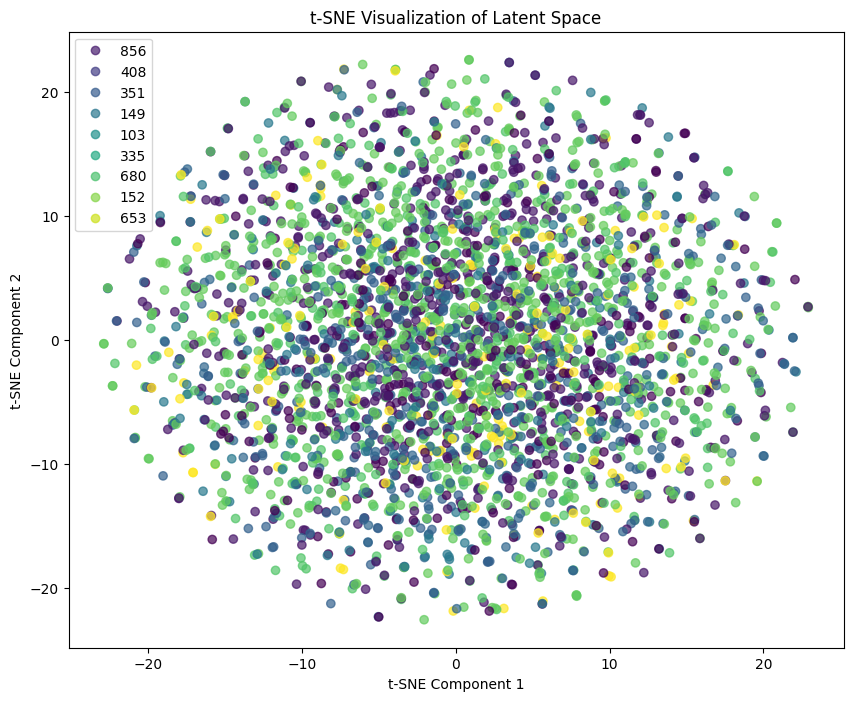

In [132]:
import torchvision.transforms as T
inception_normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
num_imgs = 10000
batch_size = 64
Inception_model.eval()
labels = []
latents = []
for i in range(10000//64):
    z = torch.randn(64,100,1,1).to(device)
    imgs = Gen(z)
    imgs = denormalise(imgs)
    imgs = F.interpolate(imgs, size=(image_size, image_size), mode="bilinear", align_corners=False)
    imgs = inception_normalize(imgs)
    with torch.no_grad():
        logits = Inception_model(imgs)
        probabilities = F.softmax(logits, dim=1).cpu().detach().numpy()
    predicted_indices = np.argmax(probabilities, axis=1)
    latents.append(z.squeeze().cpu().numpy())
    labels.append(predicted_indices)
    
latent_vectors = np.concatenate(latents,axis = 0)
labels = np.concatenate(labels,axis = 0)
unique_elements, counts = np.unique(labels, return_counts=True)
sorted_indices = np.argsort(counts)
elems = unique_elements[sorted_indices]
elems = elems[-10:]

indices = np.isin(labels, elems)
labels = labels[indices]
latent_vectors = latent_vectors[indices]

print("done with the batch")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)

plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(elems))
plt.show()
